# Probabilistic Analyses - Part I

This document derives analytic expressions for several adversarial Peras scenarios and plots the results.

## Set up

In [1]:
require(data.table)
require(ggplot2)
require(ggExtra)
require(magrittr)

## Notation

Let $\tau$ be the voting-quorum size and let $U$ be the length (in slots) of a voting round.

Let $\beta$ be the probability of the holder of one lovelace of stake being selected for voting-committee membership. Because this process is binomially distributed, the mean committee size will be $C = T \beta$, where $T$ is the total stake in the blockchain.

Let $H$ be the honest stake and let $f = \frac{T - H}{T}$ be the fraction of adversarial stake

Let $A$ be the certificate-experation time, measured in slots.

Let $\alpha$ be the active-slot coefficient.

## No honest quorum in round

Consider the situation where the adversary decides not to vote in a round, in order to prevent a quorum from occurring and forcing the chain into a cool-down period. This occurs when the number of honest voters is less than the quorum size.

$$
p_\text{nhq} = P \left( \text{honest votes} < \tau \right) \\
 = \sum_{k=0}^{\lfloor\tau\rfloor} {H\choose{k}} \beta^k (1 - \beta)^{H-k} \\
 \approx N_\text{CDF} \left( \frac{\tau - H \beta}{\sqrt{H \beta (1 - \beta)}} \right)
$$

where $N_\text{CDF}(x)$ is the unit normal cumulative probability distribution function, since the honest stake $H$ is large.

For illustration, set the recommended quorum to three-quarters of the committee size, $\tau = \frac{3}{4}C$. Hence, for committee sizes much smaller than the total stake,

$$
p_\text{nhq} \approx N_\text{CDF} \left( \left( f - \frac{1}{4} \right) \sqrt{\frac{C}{1 - f}} \right)
$$.

If we're actually only interested in small probabilities, we can even use an asympototic expansion (Mill's ratio) to simplify the result for large committees:

$$
p_\text{nhq} \approx \frac{4}{1 - 4 f} \sqrt{\frac{1 - f}{2 \pi C}} e^{-\frac{(4 f - 1)^2 C}{32 (1 - f)}}
$$.

In [2]:
pnhq <- CJ(f=0:250/1000, C=1:100*10)
pnhq[, P_nhq:=pnorm((f - 1/4) * sqrt(C/(1-f)))]
pnhq %>% summary

       f               C              P_nhq          
 Min.   :0.000   Min.   :  10.0   Min.   :0.0000000  
 1st Qu.:0.062   1st Qu.: 257.5   1st Qu.:0.0000173  
 Median :0.125   Median : 505.0   Median :0.0063179  
 Mean   :0.125   Mean   : 505.0   Mean   :0.0838123  
 3rd Qu.:0.188   3rd Qu.: 752.5   3rd Qu.:0.1189459  
 Max.   :0.250   Max.   :1000.0   Max.   :0.5000000  

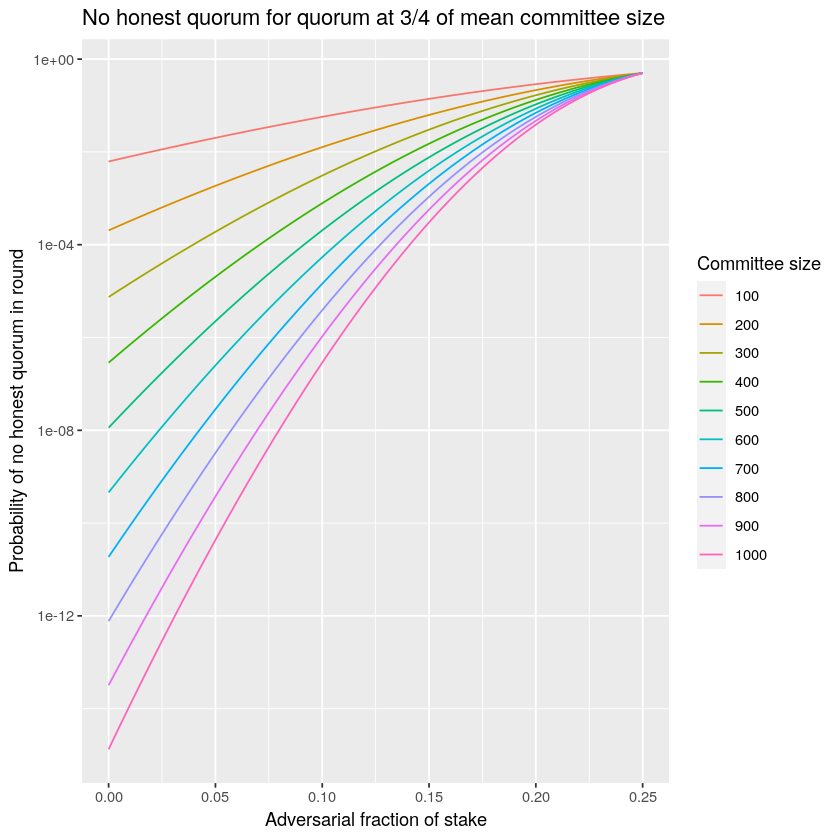

In [3]:
ggplot(pnhq[`C` %in% (1:10*100)], aes(x=`f`, y=`P_nhq`, color=factor(C))) +
  geom_line() +
  scale_y_log10() +
  xlab("Adversarial fraction of stake") +
  ylab("Probability of no honest quorum in round") +
  guides(color=guide_legend(title="Committee size")) +
  ggtitle("No honest quorum for quorum at 3/4 of mean committee size")

In [4]:
ggsave(filename="pnhq-line.png", width=6, height=4, dpi=200, units="in")
ggsave(filename="pnhq-line.svg", width=6, height=4, dpi=200, units="in")

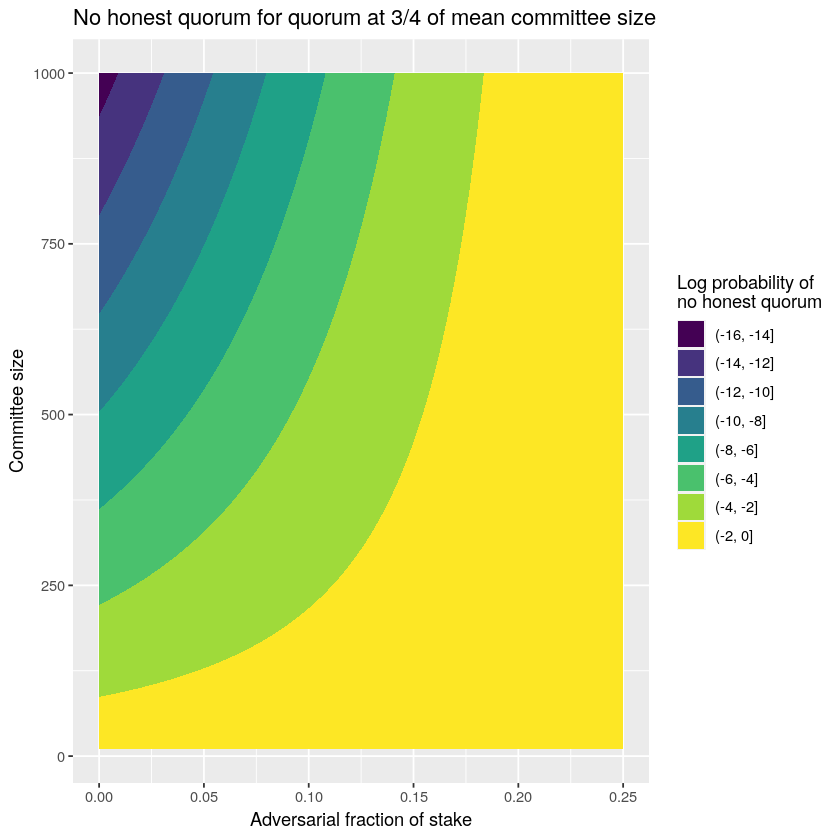

In [5]:
ggplot(pnhq, aes(f, C, z=log10(P_nhq))) +
  geom_contour_filled() +
  xlab("Adversarial fraction of stake") +
  ylab("Committee size") +
  guides(fill=guide_legend(title="Log probability of\nno honest quorum")) +
  ggtitle("No honest quorum for quorum at 3/4 of mean committee size")

In [6]:
ggsave(filename="pnhq-contour.png", width=6, height=4, dpi=200, units="in")
ggsave(filename="pnhq-contour.svg", width=6, height=4, dpi=200, units="in")

## Fraction of time in cool-down period

Consider the situation where adversarial conditions repeated force a cool-down period. Let $p_c$ be the probability of entering a cool-down period in any given round and let $c$ be the average duration of the period, in rounds.

$$
F_c = \left(1 + (p_c K)^{-1} \right)^{-1} \\
 \approx p_c K
$$

In [7]:
fc <- CJ(p_c=1/10^(0:100/10), K=1:100*10)
fc[, F_c:=1/(1 + 1 / p_c / K)]
fc %>% summary

      p_c                 K               F_c           
 Min.   :0.000000   Min.   :  10.0   Min.   :0.0000000  
 1st Qu.:0.000000   1st Qu.: 257.5   1st Qu.:0.0000114  
 Median :0.000010   Median : 505.0   Median :0.0037830  
 Mean   :0.048140   Mean   : 505.0   Mean   :0.2605620  
 3rd Qu.:0.003162   3rd Qu.: 752.5   3rd Qu.:0.5580429  
 Max.   :1.000000   Max.   :1000.0   Max.   :0.9990010  

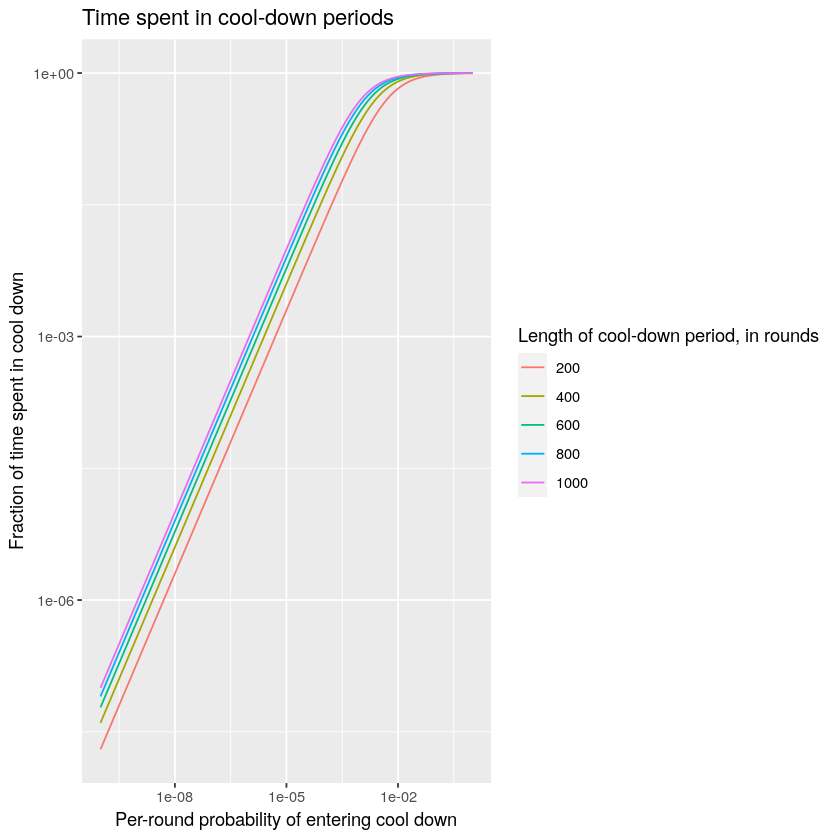

In [8]:
ggplot(fc[`K` %in% (1:5*200)], aes(x=`p_c`, y=`F_c`, color=factor(K))) +
  geom_line() +
  scale_x_log10() +
  scale_y_log10() +
  xlab("Per-round probability of entering cool down") +
  ylab("Fraction of time spent in cool down") +
  guides(color=guide_legend(title="Length of cool-down period, in rounds")) +
  ggtitle("Time spent in cool-down periods")

In [9]:
ggsave(filename="pc-line.png", width=6, height=4, dpi=200, units="in")
ggsave(filename="pc-line.svg", width=6, height=4, dpi=200, units="in")

## No certificate in honest block

Consider the situation where the voting certificate must be included on the chain (perhaps because it has entered cool-down period). The probability that adversaries forge every block during the period when the certificate hasn't expired is

$$
p_\text{nc} = P \left( \text{no honest blocks for $A$ slots} \right) \\
 = \left( (1 - \alpha)^{H / T} \right)^A \\
 = (1 - \alpha)^{(1 - f) A}
$$

In [10]:
pnc <- CJ(f=0:250/1000, A=1:80*10)
pnc[, P_nc:=(1 - 1/20)^((1 - f) * A)]
pnc %>% summary

       f               A              P_nc          
 Min.   :0.000   Min.   : 10.0   Min.   :0.0000000  
 1st Qu.:0.062   1st Qu.:207.5   1st Qu.:0.0000000  
 Median :0.125   Median :405.0   Median :0.0000000  
 Mean   :0.125   Mean   :405.0   Mean   :0.0222603  
 3rd Qu.:0.188   3rd Qu.:602.5   3rd Qu.:0.0001074  
 Max.   :0.250   Max.   :800.0   Max.   :0.6806550  

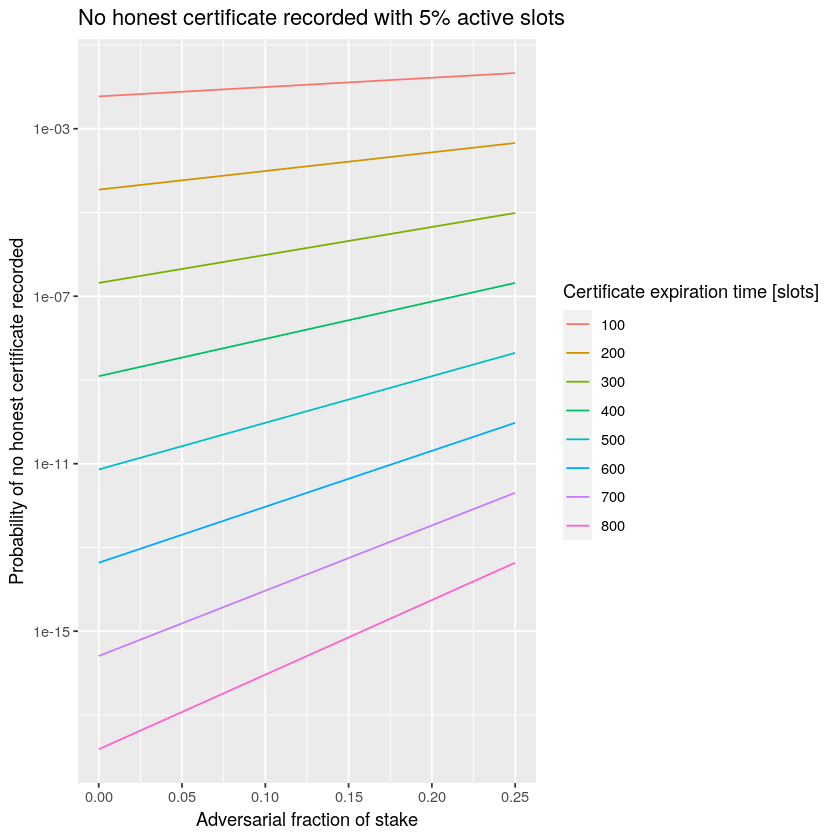

In [11]:
ggplot(pnc[`A` %in% (1:8*100)], aes(x=`f`, y=`P_nc`, color=factor(A))) +
  geom_line() +
  scale_y_log10() +
  xlab("Adversarial fraction of stake") +
  ylab("Probability of no honest certificate recorded") +
  guides(color=guide_legend(title="Certificate expiration time [slots]")) +
  ggtitle("No honest certificate recorded with 5% active slots")

In [12]:
ggsave(filename="pnc-line.png", width=6, height=4, dpi=200, units="in")
ggsave(filename="pnc-line.svg", width=6, height=4, dpi=200, units="in")

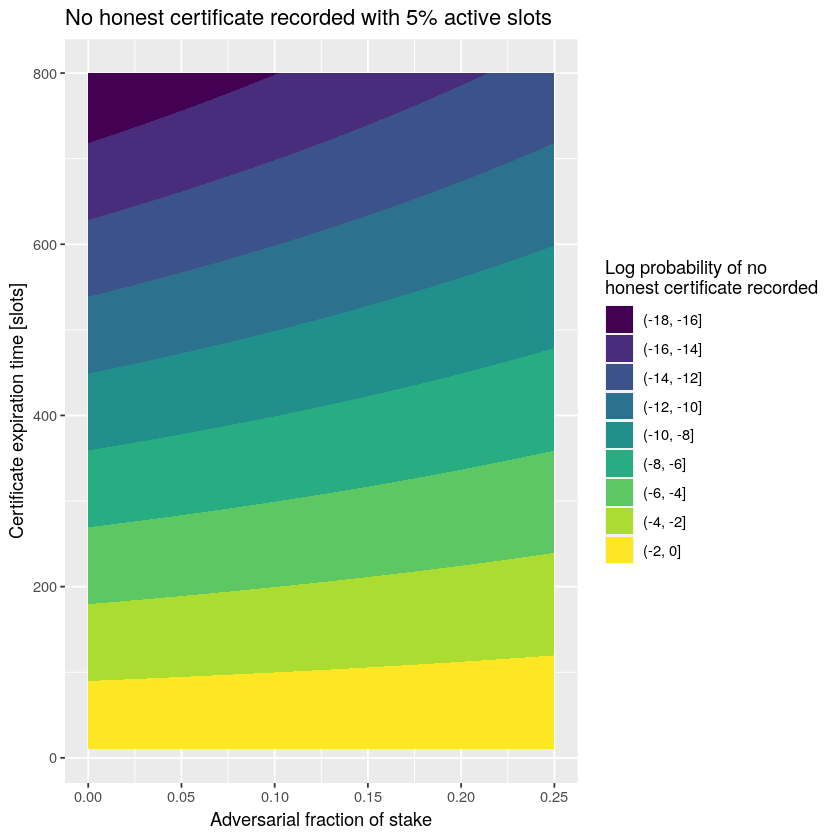

In [13]:
ggplot(pnc, aes(f, A, z=log10(P_nc))) +
  geom_contour_filled() +
  xlab("Adversarial fraction of stake") +
  ylab("Certificate expiration time [slots]") +
  guides(fill=guide_legend(title="Log probability of no\nhonest certificate recorded")) +
  ggtitle("No honest certificate recorded with 5% active slots")

In [14]:
ggsave(filename="pnc-contour.png", width=6, height=4, dpi=200, units="in")
ggsave(filename="pnc-contour.svg", width=6, height=4, dpi=200, units="in")

## Forge an adversarial block and adversarial quorum for it

We combine the probability for producing an adversarial block, $p_\text{ab}$, and the probability for producing an adversarial quorum, $p_\text{aq}$, to yield the probability of adversarial voting for an adversarial quorum, $p_\text{abq}$.

$$
p_\text{ab} = 1 - (1 - \alpha)^f \\
p_\text{aq} = \sum_{k=\lceil \tau \rceil}^{T-H} {{T - H} \choose{k}} \beta^k (1 - \beta)^{T-H-k} \\
p_\text{abq} = p_\text{ab} p_\text{aq} \\
 \approx \left( 1 - (1 - \alpha)^f \right) \left( 1 - N_\text{CDF} \left( \frac{\tau - (T - H) \beta}{\sqrt{(T - H) \beta (1 - \beta)}} \right) \right) \\
 \approx \left( 1 - (1 - \alpha)^f \right) N_\text{CDF} \left( - \left( \frac{3}{4} - f \right) \sqrt{\frac{C}{f}} \right)
$$

, where we require a quorum size $\tau = \frac{3}{4} C$.

In [15]:
pabq <- CJ(f=0:750/1000, C=1:100*10)
pabq[, P_abq:=(1 - (1 - 1/20)^f) * pnorm(- (3/4 - f) * sqrt(C/(f)))]
pabq %>% summary

       f               C              P_abq          
 Min.   :0.000   Min.   :  10.0   Min.   :0.000e+00  
 1st Qu.:0.187   1st Qu.: 257.5   1st Qu.:0.000e+00  
 Median :0.375   Median : 505.0   Median :0.000e+00  
 Mean   :0.375   Mean   : 505.0   Mean   :9.223e-04  
 3rd Qu.:0.563   3rd Qu.: 752.5   3rd Qu.:7.500e-08  
 Max.   :0.750   Max.   :1000.0   Max.   :1.887e-02  

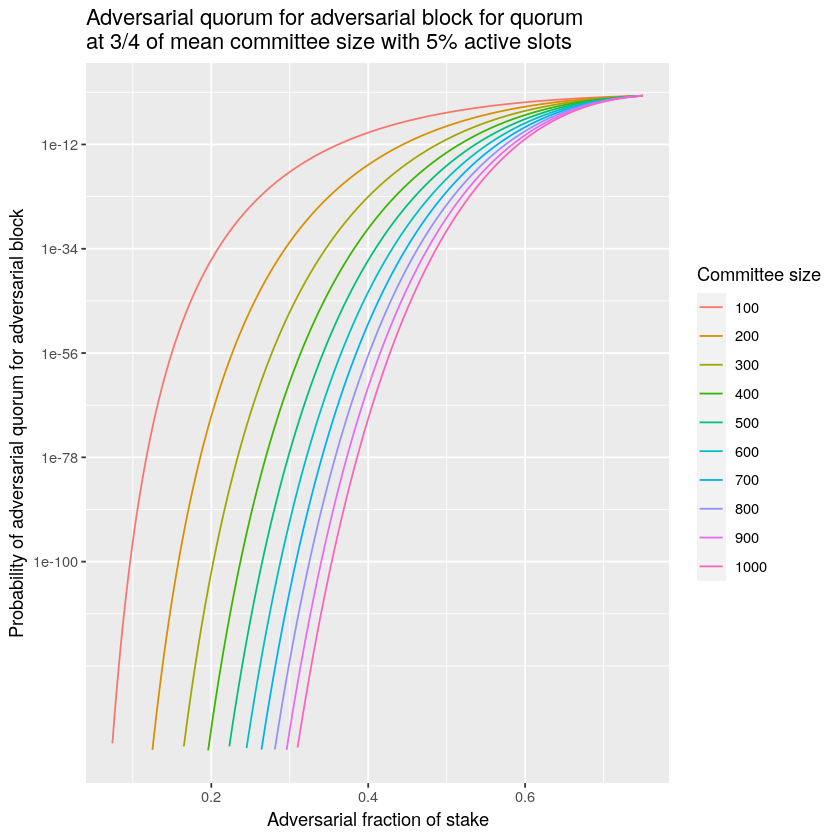

In [16]:
ggplot(pabq[`C` %in% (1:10*100)][`P_abq` > 1e-140], aes(x=`f`, y=`P_abq`, color=factor(C))) +
  geom_line() +
  scale_y_log10() +
  xlab("Adversarial fraction of stake") +
  ylab("Probability of adversarial quorum for adversarial block") +
  guides(color=guide_legend(title="Committee size")) +
  ggtitle("Adversarial quorum for adversarial block for quorum\nat 3/4 of mean committee size with 5% active slots")

In [17]:
ggsave(filename="pabq-line.png", width=6, height=4, dpi=200, units="in")
ggsave(filename="pabq-line.svg", width=6, height=4, dpi=200, units="in")